# Задание 2.
## Автор: Понамарёв Валерий, ВМК-41

Опишем класс KNN:

In [87]:
import numpy as np
import pandas as pd

def euclidean_distance(X, Y):
    return np.sqrt(np.sum(np.power(X, 2), axis=1)[:, np.newaxis] + np.sum(np.power(Y, 2), axis=1)[np.newaxis, :] - np.dot(X, Y.T) * 2)

class KNNClassifier:
    def __init__(self, k=5, weights=True):
        self.k = k
        self.weights = weights

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.classes = np.unique(y)

    def find_kneighbors(self, X, return_distance=True):
        distances = euclidean_distance(X, self.X_train)
        if return_distance is True:
            return np.sort(distances, axis=1)[:, :self.k], np.argsort(distances, axis=1)[:, :self.k]
        else:
            return np.argsort(distances, axis=1)[:, :self.k]
        
    def predict(self, X):
        distances, indeces = self.find_kneighbors(X, return_distance=True)
        nearest_classes = self.y_train[indeces]
        
        def discriminant_function(cls):
            if self.weights is True:
                return np.sum((nearest_classes == cls) / (distances + 0.00001), axis=1)
            else:
                return np.sum(nearest_classes == cls, axis=1)
              
        discriminant_function_values = np.array(list(map(discriminant_function, self.classes)))
        return self.classes[np.argmax(discriminant_function_values, axis=0)]

Загрузим данные и устраним пропуски, заменив их на средние значения:

In [114]:
data = pd.read_csv('data_full.csv')
data.loc[data['MonthlyIncome'].isna(), 'MonthlyIncome'] = data['MonthlyIncome'].mean()
data.loc[data['NumberOfDependents'].isna(), 'NumberOfDependents'] = data['NumberOfDependents'].mean()

Сформируем метки и признаки:

In [115]:
y = data['SeriousDlqin2yrs']
X = data.drop(columns=['Id', 'SeriousDlqin2yrs'])

Нормируем данные (проигнорируем тот факт, что среди признаков есть категориальные):

In [116]:
MEAN = X.mean()
STD = X.std()
X = (X - X.mean()) / X.std()

Сформируем тестовые и обучающие выборки:

In [117]:
indices = np.arange(len(y))
np.random.shuffle(indices)

X_train = X.loc[indices[:int(len(indices) * 0.99)], :]
X_test = X.loc[indices[int(len(indices) * 0.99):], :]

y_train = np.array(y[indices[:int(len(indices) * 0.99)]])
y_test = np.array(y[indices[int(len(indices) * 0.99):]])

Качество на всех признаках:

In [92]:
model = KNNClassifier(k=5)
model.fit(X_train, y_train)
res = model.predict(X_test)
print(np.sum(res == y_test) / len(y_test))

C:\Users\valeryi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """
C:\Users\valeryi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


0.916


В датасете неравномерно распределены метки **0** и **1**, первых значительно больше:

In [93]:
y.groupby(y).count()

SeriousDlqin2yrs
0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

Попробуем построить графики, повторив прошлые этапы, исключив признаки и оставив только 2 из них, например, возраст и месячный доход:

In [95]:
model = KNNClassifier(k=5)
model.fit(X_train[['age', 'MonthlyIncome']], y_train)
res = model.predict(X_test[['age', 'MonthlyIncome']])
print(np.sum(res == y_test) / len(y_test)) 

C:\Users\valeryi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  """
C:\Users\valeryi\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


0.9073333333333333


Качество немного упало, относительно того результата, что был получен при полном наборе признаков. Посмотрим на распределение меток у тестовой выборки:

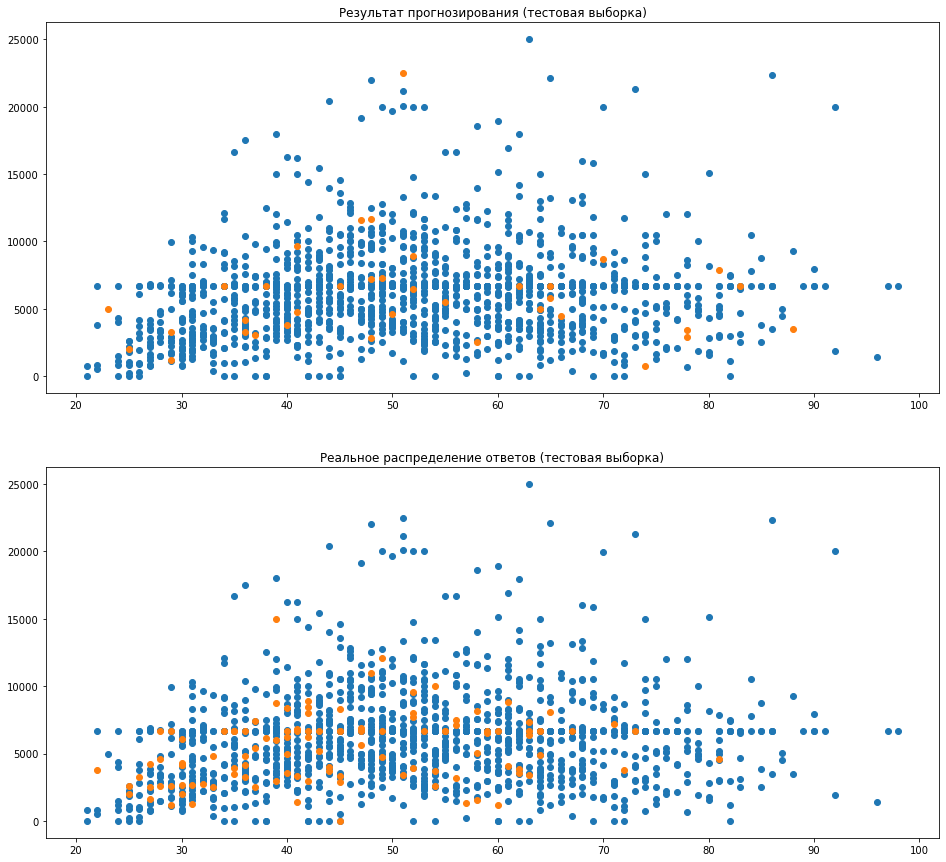

In [145]:
import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 15))

x = X_test * STD + MEAN
x_ = x[x['MonthlyIncome'] <= 25000]
res_ = res[x['MonthlyIncome'] <= 25000]
y_true = y_test[x['MonthlyIncome'] <= 25000]

ax1.set_title('Результат прогнозирования (тестовая выборка)')
ax2.set_title('Реальное распределение ответов (тестовая выборка)')

ax1.scatter(x_['age'][res_ == 0], x_['MonthlyIncome'][res_ == 0])
ax1.scatter(x_['age'][res_ == 1], x_['MonthlyIncome'][res_ == 1])

ax2.scatter(x_['age'][y_true == 0], x_['MonthlyIncome'][y_true == 0])
ax2.scatter(x_['age'][y_true == 1], x_['MonthlyIncome'][y_true == 1])

Метод k-ближайших соседей показал высокий результат, но не стоит обманываться, - это произошло из-за распределения меток в данных, количество меток **0** в 13 раз больше меток **1**, большая часть ошибок допускается на прогнозировании объектов типа **1**. Обычное вычисление доли правильных ответов не очень информативно, вместо этого следует использовать ROC-метрику, в таком случае будет видно, что алгоритм справляется не самым лучшим образом. В работе был игнорирован важный факт - наличие категориальных признаков, неверно их рассматривать как вещественные. Использование большего числа признаков (в рамках данной задачи, где общее количество признаков не велико, это работает, но это не верно для всех задач), приведёт к увеличению качества. Следует также поэксперементировать с различными функциями расстояния, как вариант - косинусное расстояние.